In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sympy as smp
from tqdm import tqdm
from sympy import Symbol, symbols
import centrex_TlF as centrex
import matplotlib.pyplot as plt
from julia import Main

In [34]:
gnd = [centrex.states.QuantumSelector(J=0, electronic = 'X'),
       centrex.states.QuantumSelector(J=2, electronic = 'X')]
exc = centrex.states.QuantumSelector(J=1, F=2, F1=3/2, electronic = 'B', P = -1)

gnd_laser = centrex.states.QuantumSelector(J=0, electronic = 'X')
exc_laser = centrex.states.QuantumSelector(J=1, F=2, F1=3/2, electronic = 'B', P = -1)

ρ_selector = centrex.states.QuantumSelector(J=0, F=1, electronic = 'X')

In [3]:
syspars = centrex.states.SystemParameters(
    nprocs  = 6,
    Γ       = 2*np.pi*1.56e6,
    ground  = gnd,
    excited = [exc]
)

In [4]:
σlaser = 0.000914

npasses = 9
multipass_offset = 0.01
distance_between_passes = 0.03556/npasses
power_loss_per_pass = 20.2/23.8

odepars = centrex.lindblad.odeParameters(
    Ωl = "Ωl0 * phase_modulation(t, β, ωphase) * multipass_2d_intensity(vz*t, y0+vy*t, ampl, xlocs, ylocs, σzlaser, σylaser)",
    Ωl0     = 1*syspars.Γ,    # Rabi frequency of the laser [rad/s]
    δl      = 0.0,              # detuning of the laser [rad/s]
    
    # laser beam properties
    σzlaser = σlaser * np.sqrt(2),
    σylaser = σlaser * np.sqrt(2),
    
    # laser multipass
    ampl = [np.sqrt(power_loss_per_pass**n) for n in range(npasses)],
    xlocs = [(n-1)*distance_between_passes + multipass_offset for n in centrex.utils.light.multipass_prism_order(npasses)],
    ylocs = npasses*[0.0],
    
    # laser phase modulation
    ωphase = syspars.Γ,       # laser phase modulation frequency [rad/s]
    β      = 3.8,             # laser phase modulation depth [rad]

    # laser polarization switching
    ωp = 2*np.pi*1.56e6,           # polarization switching frequency [rad/s]
    φp = 0.0,                 # polarization switching phase [rad]
    Pl  = "sin(ωp*t + φp)",
    Plz = "Pl>0",
    Plx = "Pl<=0",
    Ply = 0.0,
    
    # molecules
    y0 = 0.,                   # molecule start y position [m]
    vz = 150.,                 # longitudinal molecular velocity [m/s]
    vy = 0.,                   # molecule vy [m/s]
)


In [5]:
transitions = [
    centrex.couplings.TransitionSelector(
        ground = 1*centrex.states.generate_coupled_states_ground_X(gnd_laser),
        excited = 1*centrex.states.generate_coupled_states_excited_B(exc_laser),
        polarizations        = [[0,0,1],[1,0,0],[0,1,0]],
        polarization_symbols = symbols("Plz     Plx     Ply"),
        Ω = smp.Symbol('Ωl', complex = True),
        δ = smp.Symbol('δl'),
        description = "laser transition",        
    ),
]

In [6]:
obe_system = centrex.lindblad.setup_OBE_system_julia(syspars, odepars, transitions, verbose=True, full_output=True, 
                                                     qn_compact=centrex.states.QuantumSelector(J=2, electronic = 'X'))

INFO:centrex_TlF.lindblad.utils_setup:generate_OBE_system: 1/6 -> Generating the reduced Hamiltonian
INFO:centrex_TlF.lindblad.utils_setup:generate_OBE_system: 2/6 -> Generating the couplings corresponding to the transitions
INFO:centrex_TlF.lindblad.utils_setup:generate_OBE_system: 3/6 -> Generating the symbolic Hamiltonian
INFO:centrex_TlF.lindblad.utils_setup:generate_OBE_system: 4/6 -> Generating the collapse matrices
INFO:centrex_TlF.lindblad.utils_setup:generate_OBE_system: 5/6 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations
INFO:centrex_TlF.lindblad.utils_setup:generate_OBE_system: 6/6 -> Generating Julia code representing the system of equations
INFO:centrex_TlF.lindblad.utils_setup:setup_OBE_system_julia: 1/3 -> Generating the preamble
INFO:centrex_TlF.lindblad.utils_setup:setup_OBE_system_julia: 2/3 -> Initializing Julia on 6 cores
INFO:centrex_TlF.lindblad.utils_setup:setup_OBE_system_julia: 3/3 -> Defining the ODE equation and param

Initialized Julia with 6 processes


## Single Trajectory

In [35]:
Ωl0 = centrex.utils.light.calculate_rabi_from_power_gaussian_beam(
                        23.8e-3,
                        obe_system.couplings[0]['main coupling'],
                        σlaser,
                        σlaser
    ).real
Ωl0/syspars.Γ

2.3359749270117636

In [36]:
odepars.Ωl0 = np.abs(Ωl0)
odepars.ωphase = 0.
odepars.ωp = 0.65*syspars.Γ

In [37]:
ρ = centrex.utils.generate_population_states(
                    ρ_selector.get_indices(obe_system.QN), 
                    len(obe_system.QN)
)
t_array, results = centrex.lindblad.do_simulation_single(odepars, (0,50e-3/odepars.vz+10e-6), ρ)

In [38]:
multipass = odepars.get_parameter_evolution(t_array, "Ωl").real

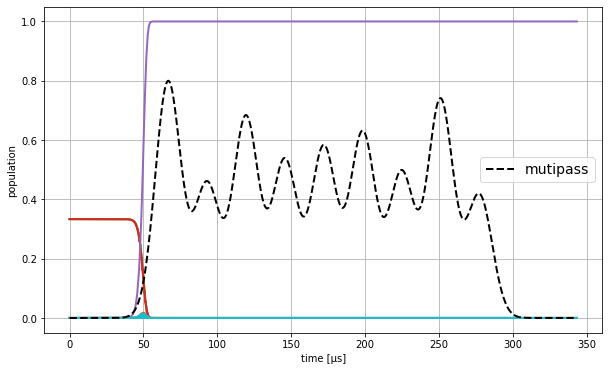

In [39]:
fig, ax = plt.subplots(figsize = (10,6)) 
ax.plot(t_array*1e6, results.T, lw = 2);
ax.plot(t_array*1e6, multipass/multipass.max()*0.8, 'k--', lw = 2,
        label = 'multipass')
ax.set_xlabel('time [μs]')
ax.set_ylabel('population')
ax.legend(fontsize = 14)
ax.grid(True)

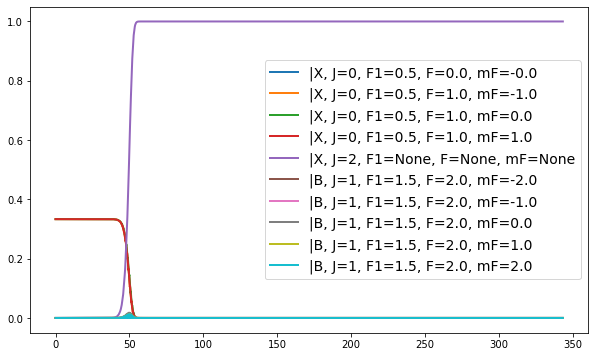

In [40]:
fig, ax = plt.subplots(figsize = (10,6))
for r, s in zip(results, obe_system.QN):
    s = s.find_largest_component()
    label = f"|{s.electronic_state}, J={s.J}, F1={s.F1}, F={s.F}, mF={s.mF}"
    ax.plot(t_array*1e6, r, lw = 2, label = label)
ax.legend(fontsize = 14)

In [41]:
np.trapz(results[exc.get_indices(obe_system.QN),:].sum(axis = 0), t_array)*syspars.Γ

1.9237962197446692

## Detuning Scan

In [14]:
%%time

odepars.Ωl0 = np.abs(Ωl0)
odepars.ωphase = 0*np.pi*1.5e6
odepars.ωp = 0.65*syspars.Γ

tspan = (0,1000e-6)


δl_scan = np.linspace(-5,5,101)*syspars.Γ

parameters = ["δl"]
values = [δl_scan]

output_func = centrex.lindblad.setup_state_integral_calculation(
                states = exc.get_indices(obe_system.QN, mode = "julia"),
                nphotons = True
            )

cb = centrex.lindblad.setup_discrete_callback_terminate(odepars, "vz*t >= 50e-3")

ens_prob = centrex.lindblad.setup_problem_parameter_scan(
                        odepars, tspan, ρ, parameters, values, 
                        dimensions = 1,
                        output_func = output_func,
                        zipped = True
            )

centrex.lindblad.solve_problem_parameter_scan(ensemble_problem_name = ens_prob, saveat = 1e-7,
                                             callback = cb)

Wall time: 26.1 s


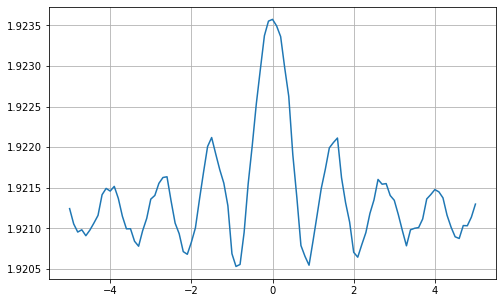

In [15]:
results = centrex.lindblad.get_results_parameter_scan()

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(δl_scan/syspars.Γ, results, '-')
ax.grid(True)

## Trajectory Scan

In [1]:
ntrajectories = 500

n = int(6e6)
vz = centrex.utils.generate_random_longitudinal_velocities(n, 150, 30)
vx, vy = centrex.utils.generate_random_transverse_velocities(n, 38)
x0, y0 = centrex.utils.generate_random_coords_circle_2D(n, 0.0025)
apertures = [(47e-3, 6.35e-3), (73e-3, 12.7e-3), (290e-3, 2.54e-3)]
mask = np.ones(n, dtype = bool)
for (location, diameter) in apertures:
    t = location / vz
    r = np.sqrt((x0+vx*t)**2 + (y0+vy*t)**2)
    m = r < diameter/2
    mask &= m
    
start_loc = 358e-3 - 0.03556/2 - 10e-3
t = start_loc / vz
x0, y0 = x0 + vx*t, y0 + vy*t

x0 = x0[mask][:ntrajectories]
y0 = y0[mask][:ntrajectories]
vx = vx[mask][:ntrajectories]
vy = vy[mask][:ntrajectories]
vz = vz[mask][:ntrajectories]

assert mask.sum() >= ntrajectories, "not enough trajectories make it through apertures"
del t, mask

δls = centrex.utils.detuning.velocity_to_detuning(vx, 1106e12, syspars.Γ)*syspars.Γ

NameError: name 'centrex' is not defined

In [17]:
%%time

odepars.Ωl0 = np.abs(Ωl0)
odepars.ωphase = 0*np.pi*1.5e6
odepars.ωp = 0.65*syspars.Γ

tspan = (0,1000e-6)

parameters = ["vz", "δl", "y0"]
values = [vz, δls, y0]

output_func = centrex.lindblad.setup_state_integral_calculation(
                states = exc.get_indices(obe_system.QN, mode = "julia"),
                nphotons = True
            )

cb = centrex.lindblad.setup_discrete_callback_terminate(odepars, "vz*t >= 50e-3")

ens_prob = centrex.lindblad.setup_problem_parameter_scan(
                        odepars, tspan, ρ, parameters, values, 
                        dimensions = 1,
                        output_func = output_func,
                        zipped = True
            )

centrex.lindblad.solve_problem_parameter_scan(ensemble_problem_name = ens_prob, saveat = 1e-7,
                                             callback = cb)

Wall time: 12.8 s


In [ ]:
results = centrex.lindblad.get_results_parameter_scan()

In [ ]:
results = centrex.lindblad.get_results_parameter_scan()
np.average(results)

In [ ]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(vz, results, '.')
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(y0, results, '.')
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(δls/syspars.Γ, results, '.')

## Detuning scan over trajectories for approximate power used in measurement

In [21]:
ntrajectories = 100

n = int(5e6)
vz = centrex.utils.generate_random_longitudinal_velocities(n, 150, 30)
vx, vy = centrex.utils.generate_random_transverse_velocities(n, 38)
x0, y0 = centrex.utils.generate_random_coords_circle_2D(n, 0.0025)
apertures = [(47e-3, 6.35e-3), (73e-3, 12.7e-3), (290e-3, 2.54e-3)]
mask = np.ones(n, dtype = bool)
for (location, diameter) in apertures:
    t = location / vz
    r = np.sqrt((x0+vx*t)**2 + (y0+vy*t)**2)
    m = r < diameter/2
    mask &= m
    
start_loc = 358e-3 - 0.03556/2 - 10e-3
t = start_loc / vz
x0, y0 = x0 + vx*t, y0 + vy*t

x0 = x0[mask][:ntrajectories]
y0 = y0[mask][:ntrajectories]
vx = vx[mask][:ntrajectories]
vy = vy[mask][:ntrajectories]
vz = vz[mask][:ntrajectories]

assert mask.sum() >= ntrajectories, "not enough trajectories make it through apertures"
del t, mask

δls = centrex.utils.detuning.velocity_to_detuning(vx, 1106e12, syspars.Γ)*syspars.Γ

In [22]:
import copy

odepars.Ωl0 = np.abs(Ωl0)
odepars.ωphase = 0*np.pi*1.5e6
odepars.ωp = 0.65*syspars.Γ

tspan = (0,1000e-6)

parameters = ["vz", "δl", "y0"]
values = [vz, δls, y0]

output_func = centrex.lindblad.setup_state_integral_calculation(
                states = exc.get_indices(obe_system.QN, mode = "julia"),
                nphotons = True
            )

δl_scan = np.arange(-30,31,2)*syspars.Γ

results = []
for δli in tqdm(δl_scan):
    vals = copy.copy(values)
    vals[1] = vals[1] + δli

    ens_prob = centrex.lindblad.setup_problem_parameter_scan(
                            odepars, tspan, ρ, parameters, vals, 
                            dimensions = 1,
                            output_func = output_func,
                            zipped = True
                )

    centrex.lindblad.solve_problem_parameter_scan(ensemble_problem_name = ens_prob, saveat = 1e-7,
                                                 callback = cb)
    res = centrex.lindblad.get_results_parameter_scan()
    results.append(np.average(res))
results = np.asarray(results)    
odepars.Ωl0 = 2.0*syspars.Γ

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [12:14<00:00, 23.71s/it]


### Fit to resonance
#### Define Gaussian and Lorentzian functions

In [23]:
from scipy.optimize import curve_fit

def gaussian(x, a, μ, σ):
    return a*np.exp(-(x-μ)**2 / (2*σ**2))

def lorentzian( x, x0, a, gam ):
    return a * gam**2 / ( gam**2 + ( x - x0 )**2)

#### Fit Lorentzian to wider scan

μ = -0.2Γ
Γ = 30.8Γ


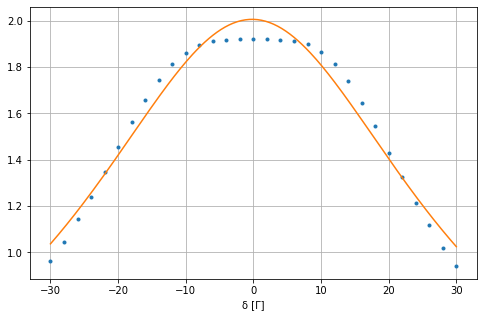

In [24]:
popt, pcov = curve_fit(lorentzian, δl_scan, results,
                       p0 = [-1.5*syspars.Γ, 2.6, 10*syspars.Γ])

x = np.linspace(δl_scan.min(), δl_scan.max(), 201)

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(δl_scan/syspars.Γ, results, '.')
ax.plot(x/syspars.Γ, lorentzian(x, *popt))
ax.set_xlabel("δ [Γ]")
ax.grid(True)

print(f"μ = {popt[0]/syspars.Γ:.1f}Γ")
print(f"Γ = {popt[2]/syspars.Γ:.1f}Γ")

#### Fit Gaussian to wider scan

μ = -0.2Γ
σ = 24.9Γ


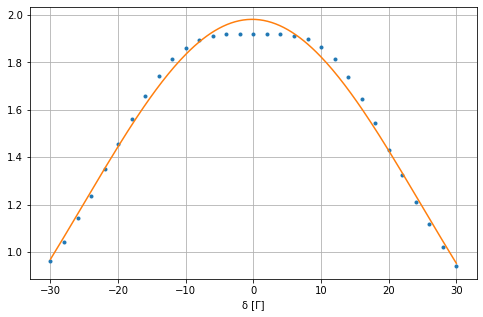

In [25]:
popt, pcov = curve_fit(gaussian, δl_scan, results,
                       p0 = [-1.5*syspars.Γ, 2.6, 10*syspars.Γ])

x = np.linspace(δl_scan.min(), δl_scan.max(), 201)

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(δl_scan/syspars.Γ, results, '.')
ax.plot(x/syspars.Γ, gaussian(x, *popt))
ax.set_xlabel("δ [Γ]")
ax.grid(True)

print(f"μ = {popt[1]/syspars.Γ:.1f}Γ")
print(f"σ = {popt[2]/syspars.Γ:.1f}Γ")